<a href="https://colab.research.google.com/github/Danko-Lab/clipnet/blob/main/clipnet_basic_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIPNET prediction and attribution map tutorial

This colab notebook contains a couple small examples of how to generate predictions and attribution maps using the CLIPNET model. Please note that this notebook is intended to be run with an NVIDIA GPU on the backend (the T4 provided in the free colab tier as of May 2025 works just fine). It will run (more slowly) on CPU, but you'll need to switch some `device="cuda"` flags to `device="cpu"`.

## Dependency installation

While CLIPNET was trained in TensorFlow, the PyTorch ecosystem is substantially more developed (and frankly easier to use) at this point, so instead of using the original reference implementation, we'll install PersonalBPNet, which contains methods for easily porting the TensorFlow models to PyTorch.

In [ ]:
!pip install --quiet "git+https://github.com/adamyhe/personalbpnet.git[tf]

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#!pip install --quiet git+https://github.com/Danko-Lab/clipnet.git

# This how you'd install the original TensorFlow implementation. Do not do that
# here, as this will cause conflicts with the PyTorch packages.

## Model downloads

CLIPNET was originally trained on a multi-individual set of B cell PRO-cap libraries. We have since fine-tuned it to predict PRO-cap in K562 and CD4+ T cells. The following models are all archived on Zenodo:
- the original [LCL PRO-cap models](https://zenodo.org/records/10408623),
- [K562 PRO-cap models](https://zenodo.org/records/15306864) (fine-tuned from the above),
- [ablated LCL PRO-cap models](https://zenodo.org/records/14037356),
- CD4+ T cell models (not yet released).

We have plans to fine-tune these models to additional transcription-related datasets, but as of May 2025, these weights are not yet public/done.

For the sake of the examples in this notebook, all we need are the LCL PRO-cap models, which we can download using the following cell.

In [ ]:
!mkdir -p clipnet_models/
# Faster to download from our ftp box, but Zenodo link provided as a backup
!wget ftp://cbsuftp.tc.cornell.edu/danko/hub/clipnet/lcl_procap/*.h5 -P clipnet_models/ --quiet
# !for i in {1..9}; do wget https://zenodo.org/records/10408623/files/fold_${i}.h5 -P clipnet_models/ --quiet; done

In [ ]:
# Import dependencies

# basics
import os
import numpy as np
import tqdm
import torch

# tangermeme functions need for predicting, interpreting, and plotting
from tangermeme.predict import predict
from tangermeme.deep_lift_shap import deep_lift_shap, _nonlinear
from tangermeme.utils import one_hot_encode
from tangermeme.plot import plot_logo

# models and additional utilities
from bpnetlite.bpnet import CountWrapper, ProfileWrapper, _ProfileLogitScaling
from personal_bpnet.clipnet_tensorflow import CLIPNET_TF, TwoHotToOneHot
from personal_bpnet.utils import plot_side

# general plotting packages
import seaborn as sns
from matplotlib import pyplot as plt

We'll look at a couple of promoter sequences here. While it's generally most convenient to use `tangermeme.io.extract_loci` to load sequences directly from a reference genome, we'll manually enter some 1kb strings here so we don't have to redownload hg38 each time someone runs this notebook. 😅

In [ ]:
# load a couple of interesting sequences.

seqs = {
    #chr13:51452691-51453690
    "ints6": "GATAGTTGAGAGGAAACTCCCCAGACCCAGTGCTCCCCGTCGTACCCCCGCCTCCGCCTCCTCCTGCCTGCCTGCCCGCTGGGGCGGGCGCCCAGCCGTCTGTCTGTCGGTTCGTCCCCCCCGCCTCGGGGGTCCCGTCCCCGCTCCCGGCCCCTGTGTGTGTCCCAGCGGGAGACGGGCCTGGCTCCCCACCCCACCCCCGGTACAGGAGTGGGGACCTGGGAGCTGGCGAAGAGGGGAGTGGGCTGAGGGAAGATTGGCCCTGGGGCTGTTGGGAGAAGTTTCAGGGACTCCCTCCGCACCCCGGCGGTGTCACCACTTTCTCAGCCCCTCTCGCTACTGAAGCGCTTTTCTCTCTCACACTCCGGTTTTAACTCGGGCAGGGGCTGCGGAGGCTCCGCCCCTGACACGTCCCCGAGCCACGTGATACACCGCCTCGCCGTTCTACTGGTCAGGCCCTATCCTTTCATTAGCATATTTAAACAGCTCAGGGGCGGGGGAAGCTTGTAGGCCGGCTCCGGGGACAGTTATTGAGCACGCGCAGAGGCGGGGCGTCGGGTGCGCGCGAGCGGGCGGGCGGGCCGACCCGGAGGCGGGCTTCGGGAAGGGGCGGGGCCGGACTGCGGAAGGACCGCGAGGTGGGGGCGGGGGCCGCGTCCGCGCGCGCGGGGCGGCCGCGGCGGTGAGCCTGCGCGTCAGGGCCGCCGGCCTCTCCTTGGCTGTTGGAGGTGATAGGGGTCGAGGGGAGGGAAAAAGGGGCTGGCGTCAGCCGCCCCTGTGAGGTGGCCGTAGCGTGGACGAGTAAGAAGGGTTGAGTAAAGTGGACAAACACCTGGTTAGGAGAAGAGGGCAGGCCCGCAGCCGCCCTCCGGAGGAGGACTCGGGGCCTCGCGGGCGCCGGAGGAGGTTCCTGGGCCTCGGAGGGCCGCCCCGGCGCGCCGCCCCGGCGCGAGCGGGCGCGGGCGGGGGAGGGGAAGTGAGAGGTTGTTTATGACCGGGG",
    #chr5:132490273-132491272
    "irf1": "GCCCCTGGCGGCTGCGCGCACGCAGATCTGCGAAAGCTGCCGGGCGCCGGCAGCCTCGTCCGGGTGGGCGGTCCACGCCGCGTCCCGCCCTCCCCGCGCCGCGGCCCGCGGCTCGCAGCTCCTCCGGCGCCCCCCGGAGCCCGCGCGGAGGCCCGGGCAACGCCGCGCGCCGGCGAGTCTCCAGCCTGGAGCTTTCGACCCCCCACTTCCTGGTGCCCCGCGCGCCTTTTATTCGACGCCGCCGGTGCCCCGCGCCTCAAAGGCGTACTCACCTCTGCTGCAGGAGCGATTCGGCGGTCGCGCGCGAGGGTCCCGGCGACGCAGGGGCTGCAGTGAGGGCGCGCGGAGCGCGACTCCGAGTGGAAGAGGGAAGAAGGCAGAGGTTGCCGGGTTCTTAAGGCCGCCGGGCACGGCCGGCGTGGACTGGGCACGGCTCCGGGTGGCCTCGGTTCGGCGGGGCTCGGGCGCACGTCTTGCCTCGACTAAGGAGTGGCGAGCTCTGCCAGGGCAGCGGCGCCACCGAGCAATCCAAACACTTAGCGGGATTCCCCAGCCCTGGCCGGCCCCGCCCCCGGACAGCCGCGCGGGCGCCCATTGGCCGGCTGCGTGCCGTCATTTCGGGGAAATCAGGCTGTTGTAGAGCTAGCGGCGAAGGGGAAGTACAGGGCGGCTGCTCCGCCCCACCCTCTCCGGCCGGGCGCCACCGCCCCGGGGCCACCGCGGGCCCGCCCCGAGCGCTCCCAATCCACCCCTGCTCCGGCTTGCCCGGAGGAGGGCTGCCCGGGACAGCCCAGCGCCCCTGGCCCCAGCCTGTCCTCTCACTCCGCCTTGTCCCAGCCGGCTGGCTCCTGGGGCCATCTTTTCACCCTCCTGGCGGGGCGGGGGCGGGGGTATATCTCCCGAACGCAGGTGAGGGGATCGCCCGGGCACTTGCCGCCCTCTCCAGTGGGAACACTGGGCCGAATCTCCCGACTGGCAGCCTGGCTCCTCAAGCTTGCCA",
    #chr11:615501-616500
    "irf7": "AGGGCTTGTAGCCACCGACGCTGCCTCGGTATGGATCTCTTGGCAGAGGGGGCTACAGGTGTGACTGCAGGTGTGGCCGGCGCGCACACATGAAGTCACAGGTGTTGAACCAGTGTCCAGGCCTGGCGGGAAGGCGCAGGCCGGACCCTGCGGAGACGGGAAAGGCGACGTCAGGGGCGGGTCAGGCTCCCGGGAAAGCGAAACCTAAACAGTGGCGCTTCGCACCCTCCTCGATCCCACCCCGTCCGGTTCTCAGCTCCGCGGAACCCCGCCTCCGCCTCCGCCTCCCTCCCCGCCCGACCCTCATCTCTCAGGCTCCCCCAGCTCTTGGCTCTACCCCTCCGGGGTCACGGAGCCCCCACGGAGGCTCTCGCTCCCGGCCTGCACCGCGTGGGTCTGGGGTCCCCAGTACCTGGGTGCCAGAGCCGCCGGGACGGGAAGTTTCGTCTCGCGGGGAAGCGGAGGGCCGGCGCTTTTATGGTGGCCAGGCGGGAGTTTCCGGGAAGGGCGCGCGCCGCCTGTTCTTATTATTGGATGCGACCAGCGGAACCCCGCCCCGGCCAGCGCGGAGTAGGGAGGAGTGGAGGGCGTTGGGAGTGGCTGCAGTGAGCCGAGATGGAGCCACTCCACTACAGCCCAGGGGACAGAGCAAGACTCAGTCTCAAAAAAAAAAGGAAGTGGGTAATGGGAGGTGGACGTGCCTCGAAAAAGGGGCAGCTGCACCGTTTGCGTTTCTTTTTTTGAGATGGAGTTTCGCTTTTGTTACCCAGGCTGGAGTGCGGTGGCACAATCTTGGCCCACCACAACCTCCGCCTCCCGGGTTCAAGTGATTCTCCTACCTAAGCCTCCCGAGTAGCTGGGATTACAGGCATGAACCACCACGCCCGGCTAATTTTGTATTTTTAGTAGAGACGGGGTTTCTCTATGTTGGTCAGGCTGGTGTCGAACTCCCGACCTCAGGTGATCTGCCCACCTCGGCCTCCCAAAGTGCTGGGATTTA",
    #chr22:43187170−43188169
    "EH38E3485200": "TCCTCCCAGCGCCCCCCCCCCCGCCCCGCCCTCCTCCCAGCCCCCCCCCGCCCCGCCCTCCTCCCAGCCCCCCCCCGCCCCGCCCTCCTCCCAGCCCCCCCCGCCTCCGCCCCCCGCCCCGCCCGCCTCCCAGCACCCCCGCCCCGTCCTCCTCCCAGCCCCCCGCCCACCGCCCCGTCCTCCCCCCAGCCCCCCGCCCCTGCCGCGCCCCCTGCCCCCGCCCCCTGCCCCCCTCCCCACCGCCCCGTCCTCCTCCCGGCCCCCCCGACCCCTCCCCTGCCCCGCCCTCTTCTCGCCCCCTCACCCCGTCCCGCCCCGCCCCCAGTCCGCCTCCAGCCCGGTTTGCCGCGGCCCCCGGGCAGGCCCTGCGCATCGGCGGGGTGCGTGCGAGAGCGCGCGAGCTTGCCAGGAGGGGGCGCGCGTCTGCGACCGCGCCTGTGGTTTGGCTGCCGCCGTGTGCGCACGCGCACCTGATGGTGGCTGAGCTTTTCTCGCTCAGCGCGCGGCGACCCCGGGGAATGCCGGGAGGGCGGGGTGCCTACGTATAGGGCGCTGTCAGGACCGGAAAAGGCCCCACCGACGGCCCGGAAGGTGTCCTGGGGCCCGAACCCGGTGAGGCGGCGCTTCTGTGCCTGCACCGGGCACACAGAGCTCGCAGGCCCCCTGCCTTGGGAGCTCTCGATTCTTGTGAGCGTTTCACCAGATTTGGATGCTGCAAAATCGTGGCCCTTCTCAATTACTTATATTTGGATTCGGAATGTCAGTTGATCCAATTAAGACCAAGTGTACCCGTCAGAGGAATTTACTCCTACATGTCGGGATGTTTCGAAGTGCAGTTGAGCTGGGCGTGGTGGCCGCGTCTGTAGTCCCAGTTACTCGGGAGGCTGAGGCGGGAGGATAGCTTGAGCCCAAGAATTCAAGTCCAGCCTCGGCAACATAGCCAGACTCCCTCTTTAAAAGAAAACAGTTCAGTTATAGAATTTCAAAAGACATTCTCTTT",
    "EH38E2695794": "CGAGATGACATCAGCTTCTAAACATAGCAAGCACCGCACCCCAACTCCATGGGCTGCGGGGGTGGGGAGGGAGTGGGGGAGGCGGGTGCTGCTGTCCCCGGGCGGGGCGTGGCGGGCAGGCCGGCCAGGCTGTGCGGGAGGAGATGACTTTGCAGGAATTGCGCTCCCAGAGTTTGCCGGCAGATCTCTCCCGCGATGGCCCGGCCAAGGGGTTAGGAAACATTCCTGCCATTCCGTGCTCTCCCCTACCCCACAAGAACCACACGCACGCACACACGCACTCTTGGATCGAATGTGCCTTTATTTATAAATCAATCCAGCCCCAGCCCAGGTTCGGTCCGGTCCCGGGAGCACCTGCGCCCCGCGTCTGCCTTCAGGCTAAGCCTGCGAGGGGTTCGGTGTGGCCCTCCCAGTGAGTCAGAATGGGCTGTGTTTCCTGTGGTTGTTGTGGAACAGTTTGTCCTTTTTACTCTCCGCCCCCCCCGCCCCGTCTCCACCCCCTTGGTAAATATAGCGCTCACGTTTCATCATCTCTTTGTCCAACGAGTGCCAGACACCCCGGCCCGCGGCCCCCGCCGCCTCCCTCCTCCTCTCCGCTCGGTTACCTCGCATAACCTCGCGCGGGCAGGCACCGGGCAGCAGCTCTCCCCGCGGCCGCGCCCGCCCGGCACCCAGCGCTTCCCGCCGCAGCACACCCCCAACCCATTCTCCCCTCCCCTTCTTCCAGTTCCCCCTTCTGTACGGCCCCCATGCTCTTGTCCCACCCCCTCTACTCGGCGTCCGGGTACTGGGTCGAGACGTGTGTAGGTGTAGGGAGGTGGATAGCCCTTTTCCGAGCCGTAGGCGTCACCCCTACGCCCAGGCCCAGGCCCAGTGCTGGATCCTGCACTTTCCCAACCTCCCCCTCCCAAGTTCCAAGGTTGCCCTCTGTTCCCCTCCCAAGCGCAGGTGACAAGCTGCTGAGACAGTGTCTGATTCACCGACAGCTGAACCAGCTACT",
    "EH38E2107427": "GGGTCCTTGTAATCTGCCAGGATAGAAATCAAGAGCGATCACCAGACATAGCAGCAAAGAGAAAGAGCTTTATTTAGCTTGTGCACGAGGGAAGTCAGCAACATGAAAGGAAGAGGGCAGGCTGCTCCCCAGGGGAGTGTGTGGGTTAGATTTCTAGGGCCTTTCTATGGAGAGGGGTTTCAGGGTTCCTCCAGGGGAGTGTGTGGGTTAGATTTCCAGGGCCTTTCTATAGGGAAGGGTTTCCCCAGGGGAGCGTGGGGGTCAGATTTCCAGGGACTTTCTGTAGGGAAGGATTTTGCCAGGGCATGTATAGGAGGAGGGGTTTCTCTAGCACTTGCACAGTGGCTCAACACACTTTTTCAAACATTGCATGTAACATCAGCATTTTAAATCTCCGTGCTTGGGCACGATTTGCAGCATTAAAATGAGGAAGAGGGTAAGTTGAAGTTTAAGTCTAACTGCACATGCGGGGCCCCAGGGAAGTCCCTAGCCCCCTAGAGCAGGAACTCGTGGTGAATAGTTTCCTGGGTCTTTGGCTGCTGATTGGCTGGAAGTCAGGTGAGCTACAGTCTGATAAGGGGTTTTTGTACTTTTTCTCTAAACCACATCAAAACCAGGAAACCAGTCAGCCTGCCTGTCTCACGAGCCCCTATTTCCTGTTGTAGATGGTGACCAGCTTGTCCTGGTTTGCTTGGAACTGTCCTGGTTTTCAAATGTAAGGTTCCACATCCTGGGCACCCCCCAGTCCTGGGCAAACCAGAATGGCTGGCCAGACTGTTGCTGTGACTGGAGTGGGGCATACCCTGCCTGCTTTTTTCTGGGCCTTACCTGCTAAGTGGTGTCCAAGGAGAGGCCCTGGGGGTCTGGGTGTGGGATGGGCTGGTGACTCGTCCCTCTGTGCCCTTCCCACCCACTCTTGCCCTCAGTGCTGGTGCCCACCTGGCATCCCGGACACCATCCAGGGCACCCTGGCTGGATGGCCTGTCTTCATGGGCCATGG",
    #chr21:33229367-33230366
    "ifnar2": "CCTATCCCGAAACACGTTGATCAGTGGGGGGTCGAGGGAAGGGTAGGAGTATGGAGAAGAGACCCGCGGAGAAGAGGGGAGAATCTACAACGGATAATGTTGTAGATATTTACAACATTTACTCAATGGTAGGTATTTTTATCCTCGTTTTACTAGTTGGAGAATTATATCATGCAGGTTTATACAATTAACAAGTGGGGGAGCCAGGAGAGAACCCATTCACTCTTTAGTTCATTCATTCATTCAGTCAGTCAACACATCTTTGGGTGTCTTCTAAATGCCAGGCACTATTCTAACCCCTAAGGATACTTCAGTAAACAAAACAGTCCCAAATTCTTCCCCTATGGAGCTTTCTCGGCGAAGGCGGGATTGGTTAGGAGCTGACAATCGGCAGCAGACGATTGTAAATGACCGGACCTTTTTTCTATTCTCCTGCCCAGCCCCCGGCCCGGCCTCCGCCTCCGGCCCTGCTCCAGCCCCGCCAGCGGCCCAGGACCCGCCCCTGGCTCCGGCCCCGCCCCTGGCTCCGCCCCCGCCCCCGCGCCGGCGGCGGCGCGGCGCCCGCGCTTCCGTATCGCTCCTCGTAGGCCGGGGCTCGGCGCGCGCACCCGCACTAAAGACGCTTCTTCCCGGCGGGTAGGAATCCCGCCGGCGAGCCGAACAGTTCCCCGAGCGCAGCCCGCGGACCACCACCCGGCCGCACGGGCCGCTTTTGTCCCCCGCCCGCCGCTTCTGTCCGAGAGGCCGCCCGCGAGGCGCATCCTGACCGCGAGCGTCGGGTCCCAGAGCCGGGCGCGGCTGGGGCCCGAGGCTAGCATCTCTCGGGAGCCGCAAGGCGAGAGCTGCAAAGGTAACGCAGCGTGGCGGGGTCGCGGGAGCGGAGCGCGTGGCCAGCTGACTGGAGGGAAAACGCCGCCTCCCTGCAGCGGTTCCCGGAATCCCCTCCGGTTCCCTCTCGCTCTCCCCGACTCCTCCTCCTCCTCCTGCCCTCCCTCTGCGT",
}
ohe = [
    one_hot_encode(seq).unsqueeze(dim=0).to(torch.float32)
    for seq in seqs.values()
  ]
ohe = torch.cat(ohe)
ohe.shape

torch.Size([7, 4, 1000])

## Model handling

Now we'll load the models into our session. Note that since the CLIPNET TensorFlow models expect inputs to be two-hot encoded, we need to wrap the PyTorch models with a small utility module that automatically doubles one-hot encoded sequences. While you could instead manually multiply `ohe * 2` for predictions, many of the other modules in tangermeme and other *post hoc* analysis packages require that the models accept one-hot encoded sequences, so we need to use [wrappers](https://tangermeme.readthedocs.io/en/latest/vignettes/Wrappers_are_Productivity_Hacks.html) to solve this compatibility issue.

In [ ]:
models = [
    TwoHotToOneHot(CLIPNET_TF.from_tf(f"clipnet_models/fold_{i}.h5"))
    for i in range(1, 10)
]

## Predictions

Now, we can use `tangermeme.predict.predict` to generate predictions. While you could directly call the model (that is, `model(X)`), using the `predict` module is much safer since it automatically handles predicting in small batches to avoid VRAM exhaustion (among other things).

In [ ]:
preds = [predict(model, ohe, device="cuda") for model in models]

Each CLIPNET model will generate a profile prediction (distribution of reads in the center 500 bp) and a counts prediction (total RPM in the 500 bp, you'll also see us call this "quantity"). We ensemble the 9 model replicates by just averaging the predictions:

In [ ]:
y_profile = torch.stack([p[0] for p in preds]).mean(dim=0)
y_counts = torch.stack([c[1] for c in preds]).mean(dim=0)

We also generally apply an affine calibration to correct some squashing effects on the counts/quantity head. Specifically (see Methods of our manuscript for more details on how we obtain this):

In [ ]:
y_counts_corr = 10 ** (1.59687745 * torch.log10(y_counts) - 0.80203685)

We can then generate scaled track predictions:

In [ ]:
y = y_profile / (y_profile.sum(dim=-1, keepdim=True) + 1e-3) * y_counts_corr

While we can now plot these tracks, we'll first generate the attribution maps so we can plot them together with the predictions.

## Attributions

We'll use DeepLIFT/SHAP to calculate attribution scores, that is, explanations of individual model predictions. Since CLIPNET models generate separate profile and quantity predictions, and DeepLIFT/SHAP wants models with a single scalar output, we need to transform these models to get just a single scalar. For the counts/quantity head, this is quite easy, as we can just slice off the profile head (`CountWrapper` from bpnetlite handles this). To explain the profile head, we'll use the `ProfileWrapper` from bpnetlite to summarize predictions from the profile head as a single scalar.

In [ ]:
# create wrapped models
counts = [CountWrapper(model) for model in models]
profile = [ProfileWrapper(model) for model in models]

# calculate attributions for each output head
c_attr = []
for c in counts:
    c_attr.append(
        deep_lift_shap(c, ohe, random_state=47, batch_size=8).detach().cpu()
    )
    torch.cuda.empty_cache()

p_attr = []
for p in profile:
    p_attr.append(
        deep_lift_shap(
            p,
            ohe,
            random_state=47,
            batch_size=8,
            additional_nonlinear_ops={
                _ProfileLogitScaling: _nonlinear
            }, # we need this to escape the a nonlinear layer in ProfileWrapper
        ).detach().cpu()
    )
    torch.cuda.empty_cache()

# average attributions across replicates
c_attr = torch.stack(c_attr).mean(dim=0)
p_attr = torch.stack(p_attr).mean(dim=0)

/usr/local/lib/python3.11/dist-packages/tangermeme/deep_lift_shap.py:436: RuntimeWarning: Convergence deltas too high: tensor([3.2902e-05, 2.1935e-05, 1.4429e-03, 9.0599e-06, 1.3351e-05, 4.7684e-06,
        1.2636e-05, 2.5272e-05], device='cuda:0', grad_fn=<AbsBackward0>)
  warnings.warn("Convergence deltas too high: " +


INTS6 promoter

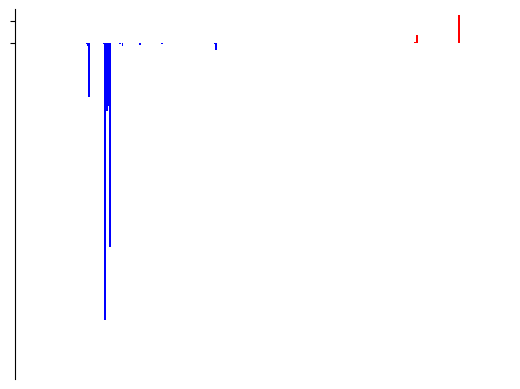

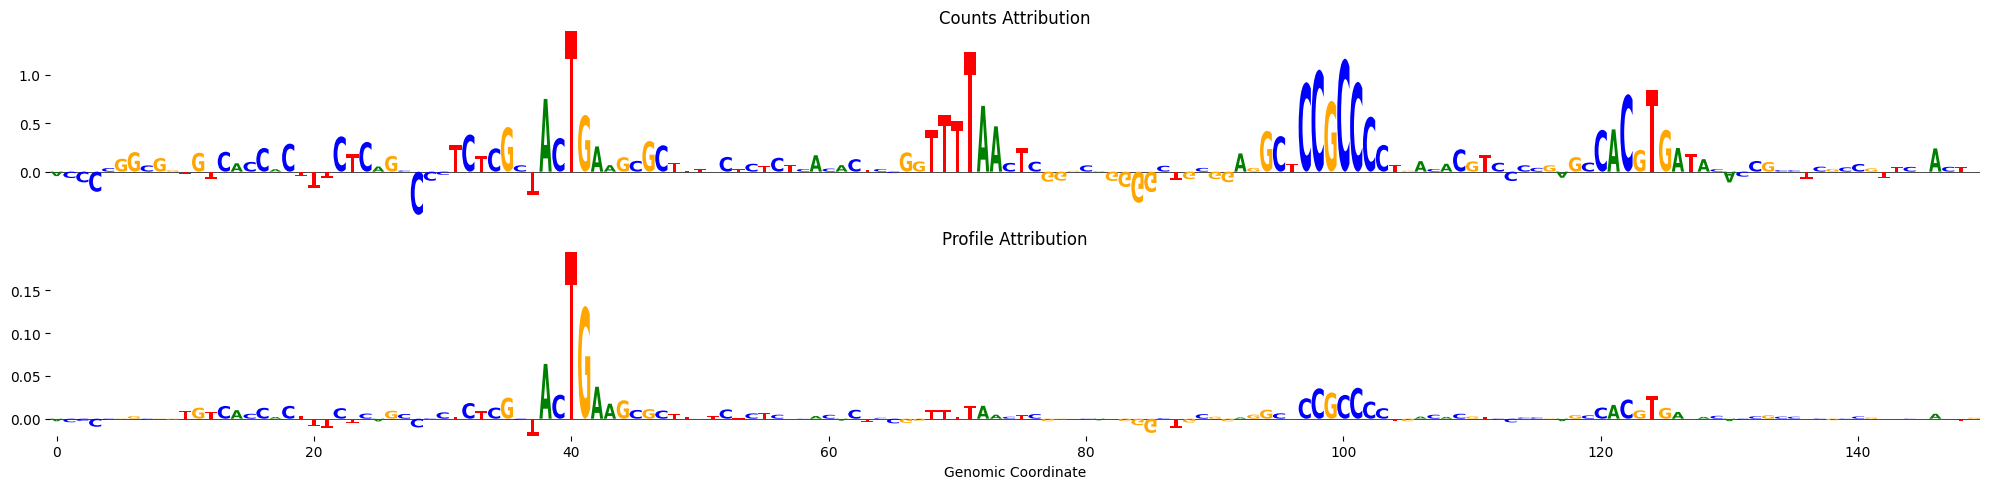

In [ ]:
# plot prediction
plot_side(y[0], ylim=[-30, 3])

# plot attributions
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(5)
fig.set_figwidth(20)
plot_logo(c_attr[0, :, c_attr.shape[-1]//2 - 200: c_attr.shape[-1]//2 - 50], ax=ax1)
plot_logo(p_attr[0, :, p_attr.shape[-1]//2 - 200: p_attr.shape[-1]//2 - 50], ax=ax2)
ax1.set_title("Counts Attribution")
ax1.set_xticks([])
ax2.set_title("Profile Attribution")
ax2.set_xlabel("Genomic Coordinate")
fig.tight_layout()
plt.show()


IRF1 promoter

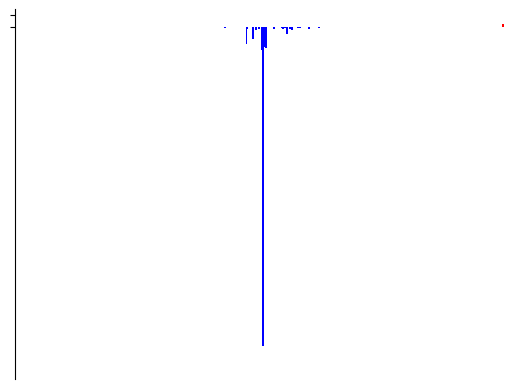

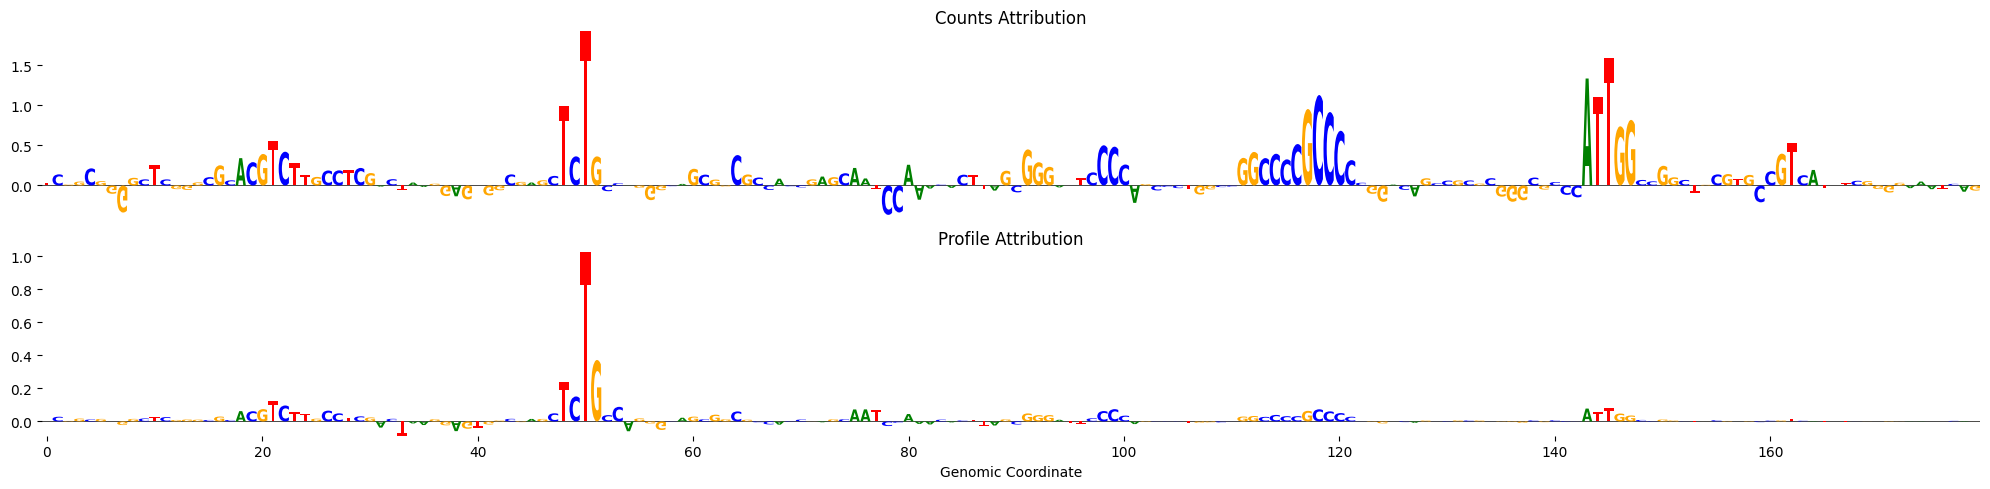

In [ ]:
# plot prediction
plot_side(y[1], ylim=[-60, 3])

# plot attributions
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(5)
fig.set_figwidth(20)
plot_logo(c_attr[1, :, c_attr.shape[-1]//2 - 50: c_attr.shape[-1]//2 + 130], ax=ax1)
plot_logo(p_attr[1, :, p_attr.shape[-1]//2 - 50: p_attr.shape[-1]//2 + 130], ax=ax2)
ax1.set_title("Counts Attribution")
ax1.set_xticks([])
ax2.set_title("Profile Attribution")
ax2.set_xlabel("Genomic Coordinate")
fig.tight_layout()
plt.show()


IRF7 promoter

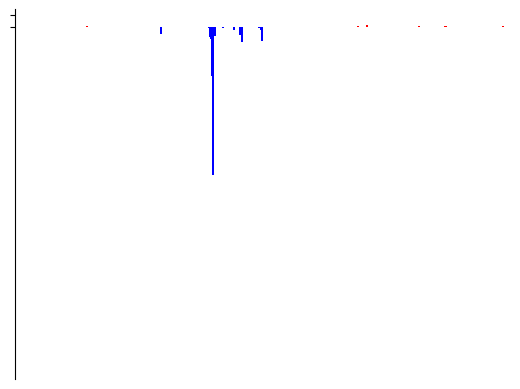

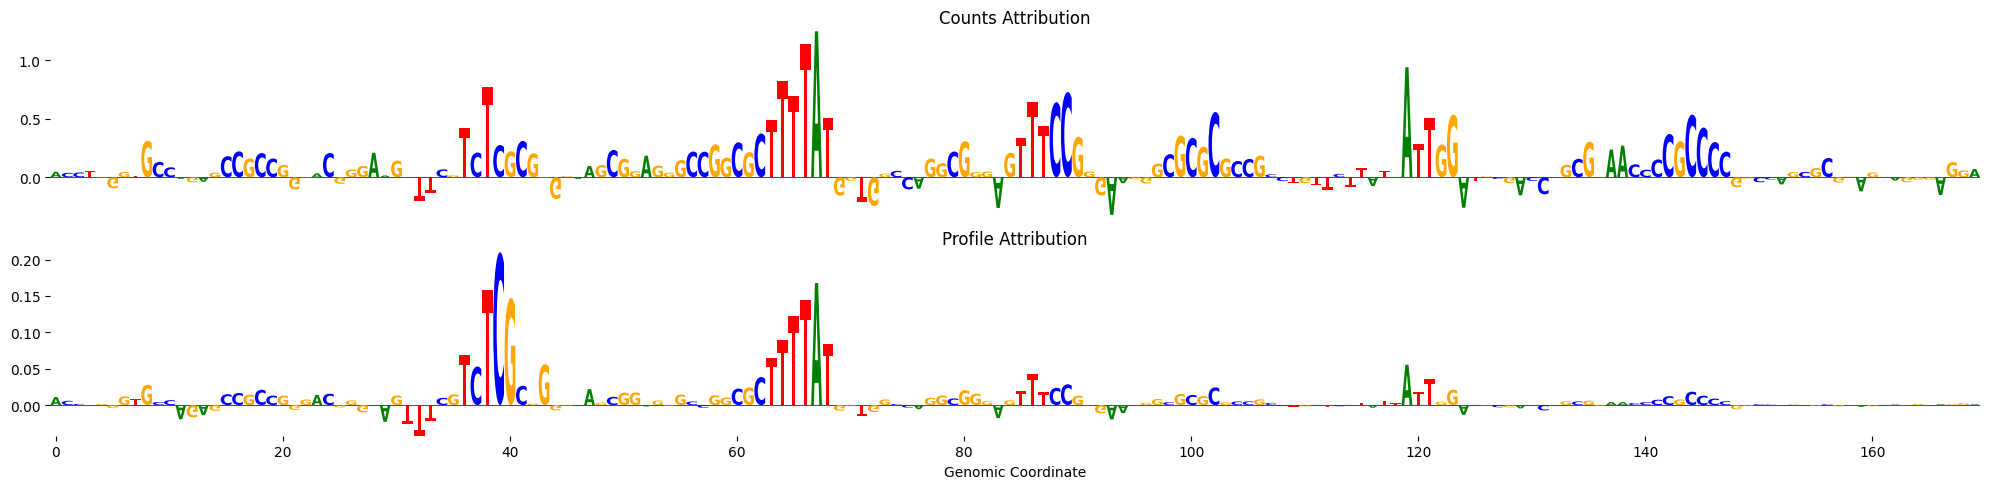

In [ ]:
# plot prediction
plot_side(y[2], ylim=[-60, 3])

# plot attributions
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(5)
fig.set_figwidth(20)
plot_logo(c_attr[2, :, c_attr.shape[-1]//2 - 90: c_attr.shape[-1]//2 + 80], ax=ax1)
plot_logo(p_attr[2, :, p_attr.shape[-1]//2 - 90: p_attr.shape[-1]//2 + 80], ax=ax2)
ax1.set_title("Counts Attribution")
ax1.set_xticks([])
ax2.set_title("Profile Attribution")
ax2.set_xlabel("Genomic Coordinate")
fig.tight_layout()
plt.show()


EH38E3485200 enhancer

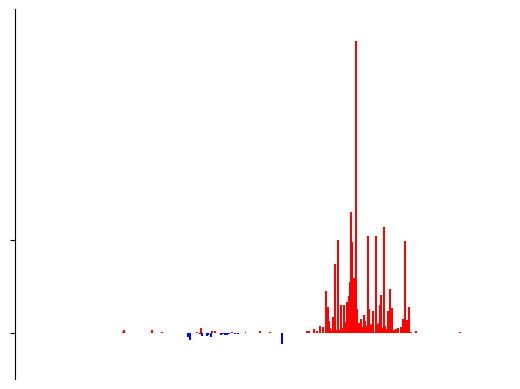

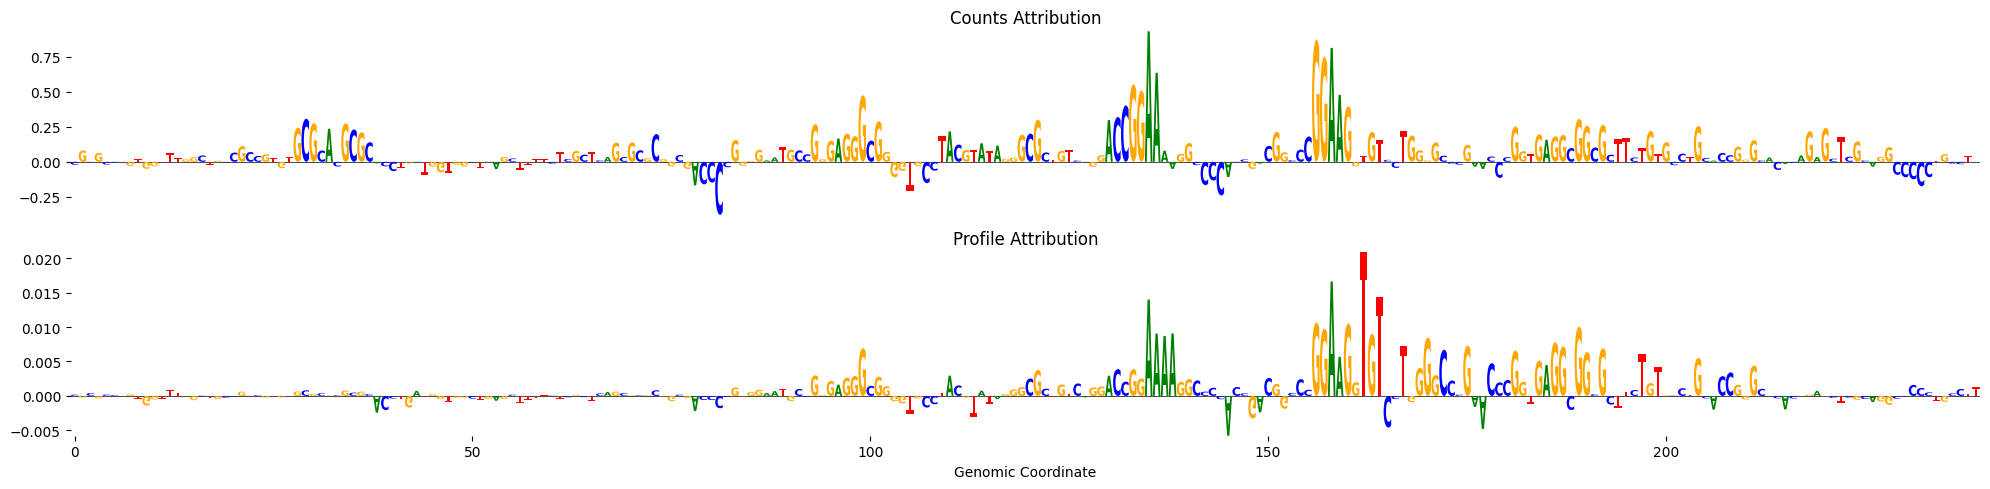

In [ ]:
# plot prediction
plot_side(y[3], ylim=[-1, 7])

# plot attributions
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(5)
fig.set_figwidth(20)
plot_logo(c_attr[3, :, c_attr.shape[-1]//2 - 70: c_attr.shape[-1]//2 + 170], ax=ax1)
plot_logo(p_attr[3, :, p_attr.shape[-1]//2 - 70: p_attr.shape[-1]//2 + 170], ax=ax2)
ax1.set_title("Counts Attribution")
ax1.set_xticks([])
ax2.set_title("Profile Attribution")
ax2.set_xlabel("Genomic Coordinate")
fig.tight_layout()
plt.show()


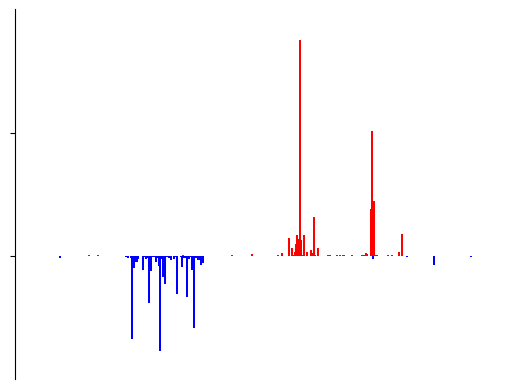

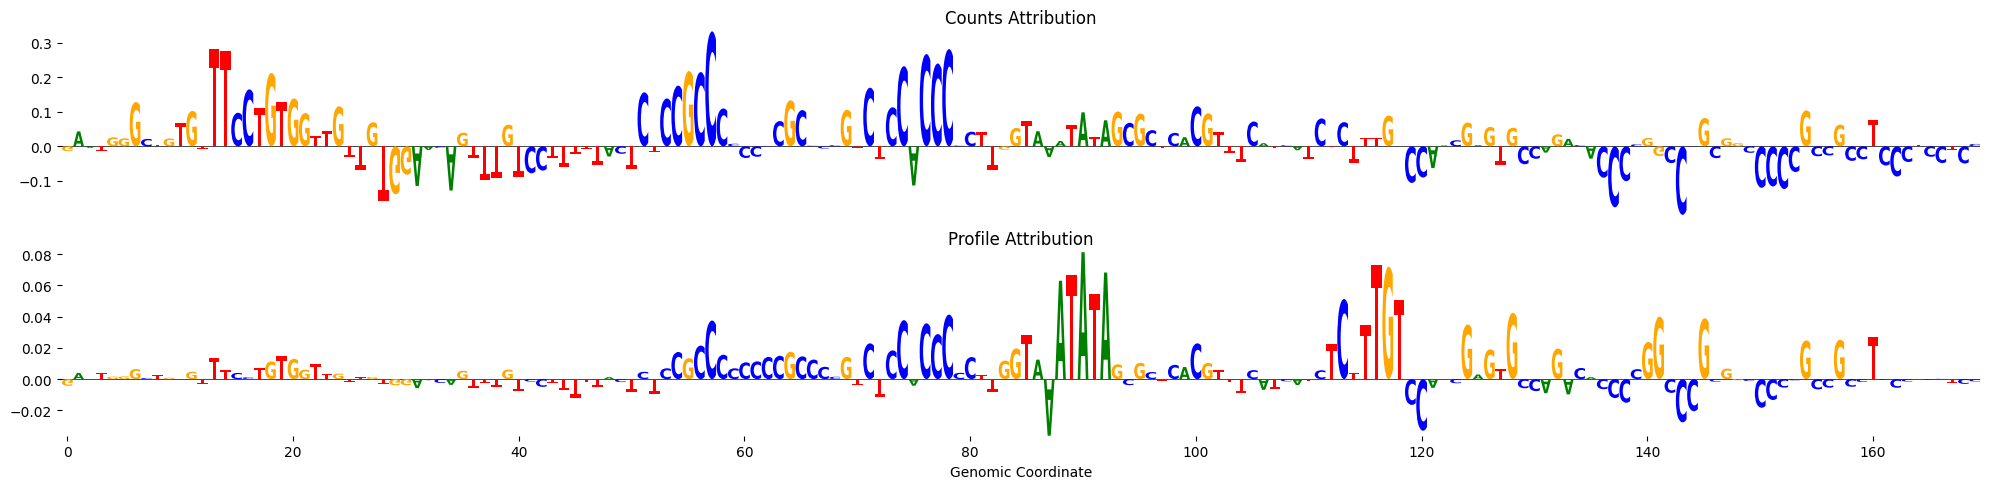

In [ ]:
# plot prediction
plot_side(y[4], ylim=[-2, 4])

# plot attributions
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(5)
fig.set_figwidth(20)
plot_logo(c_attr[4, :, c_attr.shape[-1]//2 - 80: c_attr.shape[-1]//2 + 90], ax=ax1)
plot_logo(p_attr[4, :, p_attr.shape[-1]//2 - 80: p_attr.shape[-1]//2 + 90], ax=ax2)
ax1.set_title("Counts Attribution")
ax1.set_xticks([])
ax2.set_title("Profile Attribution")
ax2.set_xlabel("Genomic Coordinate")
fig.tight_layout()
plt.show()


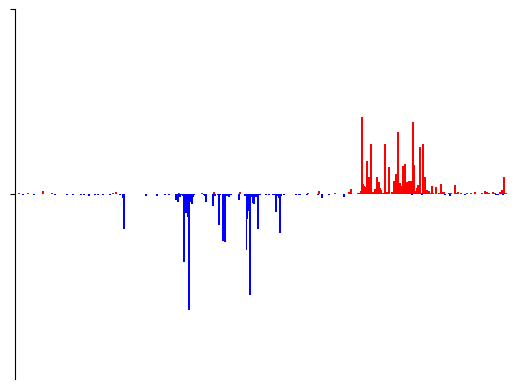

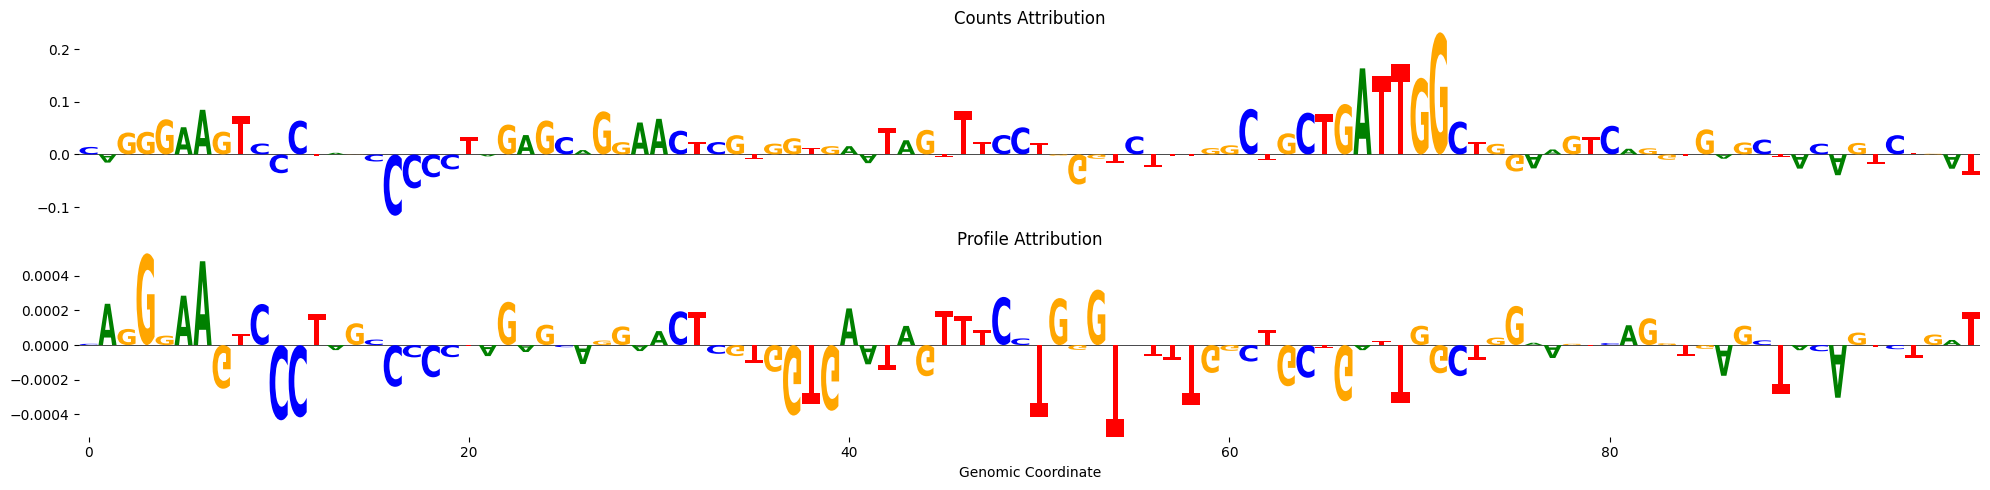

In [ ]:
# plot prediction
plot_side(y[5], ylim=[-1, 1], yticks=[0,1])

# plot attributions
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(5)
fig.set_figwidth(20)
plot_logo(c_attr[5, :, c_attr.shape[-1]//2 - 25: c_attr.shape[-1]//2 + 75], ax=ax1)
plot_logo(p_attr[5, :, p_attr.shape[-1]//2 - 25: p_attr.shape[-1]//2 + 75], ax=ax2)
ax1.set_title("Counts Attribution")
ax1.set_xticks([])
ax2.set_title("Profile Attribution")
ax2.set_xlabel("Genomic Coordinate")
fig.tight_layout()
plt.show()


IFNAR2 promoter

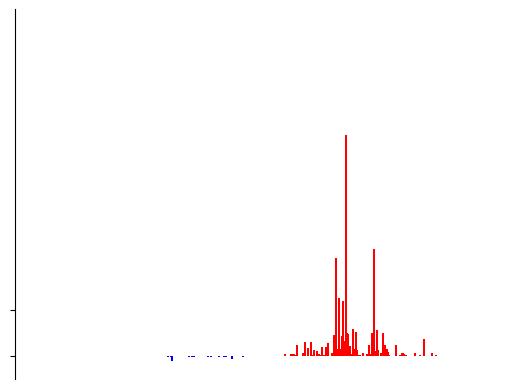

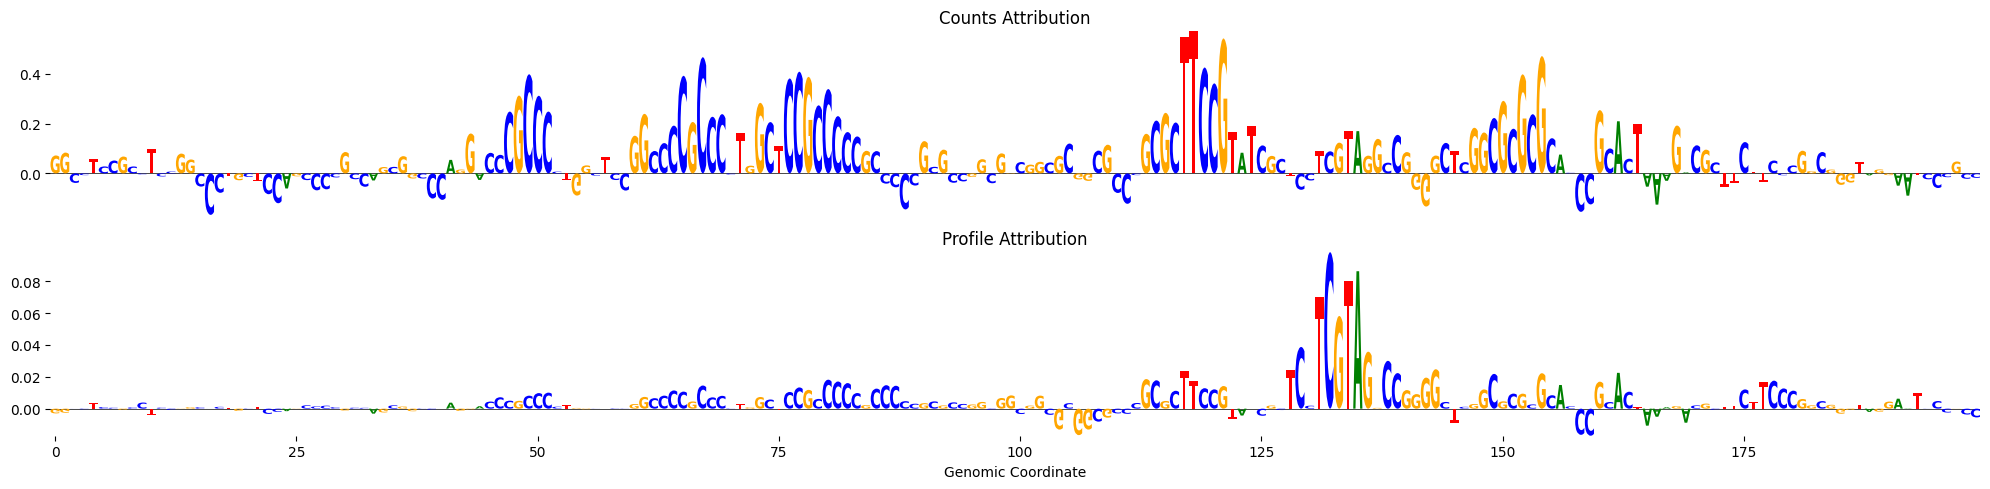

In [ ]:
# plot prediction
plot_side(y[6], ylim=[-1, 15])

# plot attributions
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(5)
fig.set_figwidth(20)
plot_logo(c_attr[6, :, c_attr.shape[-1]//2 - 50: c_attr.shape[-1]//2 + 150], ax=ax1)
plot_logo(p_attr[6, :, p_attr.shape[-1]//2 - 50: p_attr.shape[-1]//2 + 150], ax=ax2)
ax1.set_title("Counts Attribution")
ax1.set_xticks([])
ax2.set_title("Profile Attribution")
ax2.set_xlabel("Genomic Coordinate")
fig.tight_layout()
plt.show()
